<a href="https://colab.research.google.com/github/isabellechiu/transfer-learning/blob/master/style_transfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Style Transfer in Pytorch
https://nextjournal.com/gkoehler/pytorch-neural-style-transfer
Implementing a neural algorithm of artistic style based on the original paper by Gatys et al.

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [0]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')  
  
  if max(image.size) > max_size:
    size = max_size
  else:
    size = max(image.size)
	
  if shape is not None:
    size = shape
  
  in_transform = transforms.Compose([
    transforms.Resize((size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image).unsqueeze(0)
  
  return image

In [0]:
style = load_image('/content/Van_Gogh_-_Starry_Night.jpg').to(device)
content = load_image('/content/Taipei_Taiwan_Skyline.png').to(device)
print(content.shape)
print(style.shape)
##This corresponds to the batch dimension, rgb channels, as well as height and width,
##which is the expected input shape for 2D convolution layers in Pytorch.

torch.Size([1, 3, 400, 582])
torch.Size([1, 3, 400, 504])


In [0]:
##Next we also want a function to do the opposite: convert an image tensor back to a numpy array which we can display. 
##For that we have to rearrange the dimensions in the right way and undo the normalization.
def im_convert(tensor):
  image = tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array(
    (0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

(-0.5, 503.5, 399.5, -0.5)

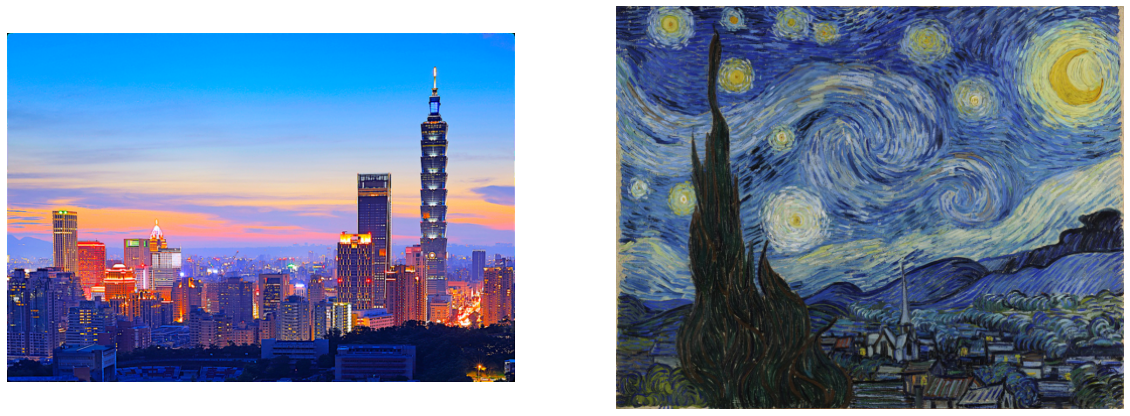

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

The function performs a forward pass through the model, one layer at a time, and stores the feature map responses if the name of the layer matches one of the keys in the predefined layer dict. This dict serves as a mapping from the Pytorch VGG19 implementation's layer indices to the layer names defined in the paper. If no layers are specified, we'll use a complete set of both the content layer and the style layers as a default.

In [0]:
def get_features(image, model):
   
    layers = {'0': 'conv1_1',
              '5': 'conv2_1', 
              '10': 'conv3_1', 
              '19': 'conv4_1',
              '21': 'conv4_2',  # Content Extraction
              '28': 'conv5_1'}
        
    features = {}
 
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features

As it turns out, style representations can be obtained by measuring the correlation between different feature map responses of a given layer, which boils down to computing the Gram matrix of the vectorised feature map. For this we take as input a feature map tensor, reshape the spatial extent (height and width) of the tensor to be one vector, and then just compute the inner product of the reshaped tensor.

In [0]:
def gram_matrix(tensor):
  _, n_filters, h, w = tensor.size()
  tensor = tensor.view(n_filters, h * w)
  gram = torch.mm(tensor, tensor.t())
  
  return gram

In [0]:
vgg = models.vgg19(pretrained=True).features
 
for param in vgg.parameters():
    param.requires_grad_(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

we also want to compute the gram matrices for all the style layers. Let's go ahead and build a dictionary with all the style gram matrices.

In [0]:
style_grams = {
  layer: gram_matrix(style_features[layer]) for layer in style_features}

Now we can create a third image, which will serve as our starting point for the image transformation process. Here we have to choose: do we start from the original content image or simply from random noise? There's definitely room to play around with different starting points.
The second line is the code we could use when choosing to start from the original content image. For this we would just have to create a copy of the content image


In [0]:
##target = torch.randn_like(content).requires_grad_(True).to(device)
target = content.clone().requires_grad_(True).to(device)

Implement the full loss function with its content and style term.

In the style term of our loss function, we'll have multiple style layers contributing. It's helpful to have different layers contribute to the style term to different extents. We can achieve this by simple multiplicative weights for each layer. This enables us to tune the style artifacts to our liking. As a tendency, larger weights for earlier layers yield larger artifacts.

In [0]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}
##we also want to have weights for the overall strength of both individual loss terms (content and style). 
content_weight = 1  # alpha
style_weight = 1e6  # beta

Total loss:  255265.484375
content fraction: 5.195755314580268e-05
style fraction: 0.9999480067231298
Iteration:  300


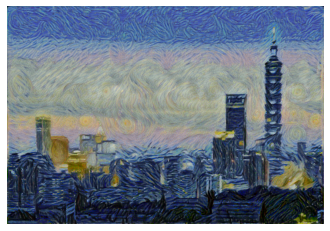

Total loss:  202579.8125
content fraction: 6.606869518978843e-05
style fraction: 0.9999338659250039
Iteration:  600


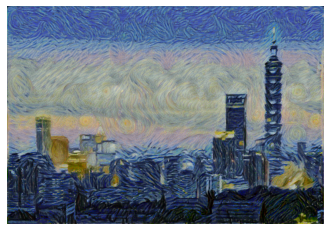

Total loss:  168737.734375
content fraction: 7.985773770651385e-05
style fraction: 0.9999201974579106
Iteration:  900


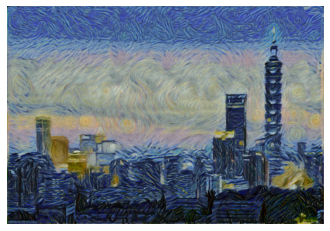

Total loss:  144776.03125
content fraction: 9.349407933648536e-05
style fraction: 0.9999065444099009
Iteration:  1200


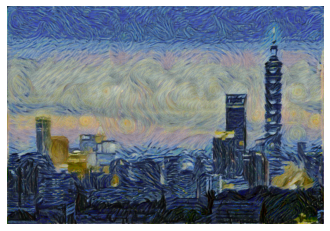

Total loss:  127494.9140625
content fraction: 0.00010656561992569373
style fraction: 0.9998934263240099
Iteration:  1500


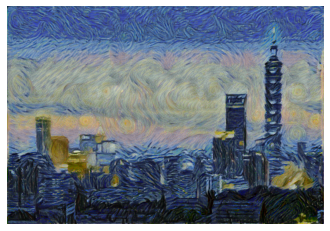

Total loss:  114219.5703125
content fraction: 0.00011921741118384153
style fraction: 0.99988080979978
Iteration:  1800


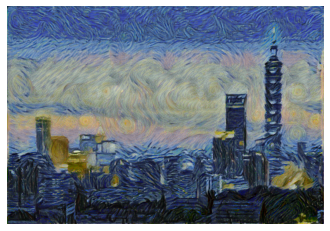

Total loss:  104229.0859375
content fraction: 0.00013094831777260302
style fraction: 0.9998690360406602
Iteration:  2100


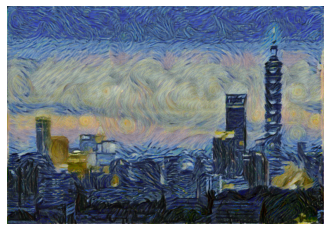

Total loss:  96601.1484375
content fraction: 0.00014146731400011258
style fraction: 0.9998585744309678
Iteration:  2400


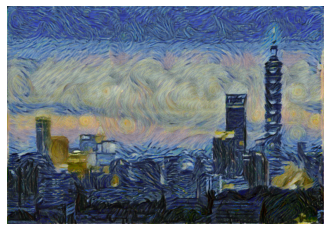

Total loss:  90310.3203125
content fraction: 0.00015144978716668422
style fraction: 0.9998485298215303
Iteration:  2700


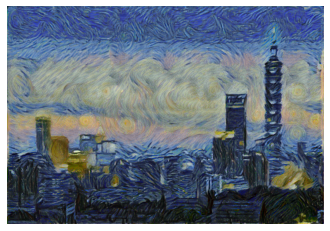

Total loss:  84883.09375
content fraction: 0.0001613986303138745
style fraction: 0.9998385834777093
Iteration:  3000


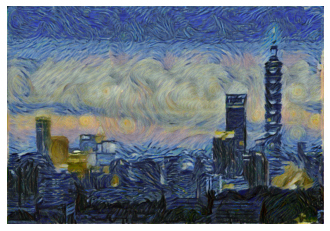

Total loss:  80836.3359375
content fraction: 0.00016968689060610723
style fraction: 0.9998302852080828
Iteration:  3300


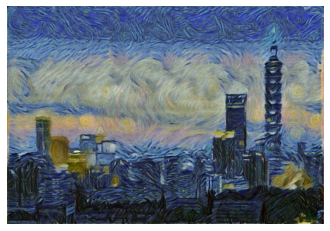

Total loss:  77307.3359375
content fraction: 0.00017766645733094643
style fraction: 0.9998223800499265
Iteration:  3600


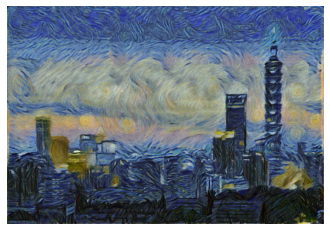

Total loss:  74636.9765625
content fraction: 0.0001841499978128183
style fraction: 0.9998158822462202
Iteration:  3900


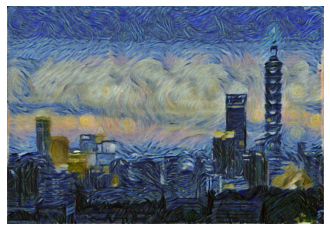

Total loss:  72239.6015625
content fraction: 0.00019030327426219646
style fraction: 0.999809692171205
Iteration:  4200


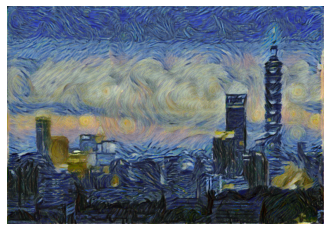

Total loss:  69704.2578125
content fraction: 0.00019748767497894284
style fraction: 0.9998025646712916
Iteration:  4500


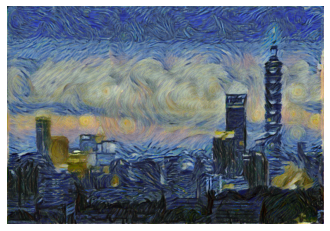

Total loss:  68325.0078125
content fraction: 0.00020158957316441145
style fraction: 0.9997984484132879
Iteration:  4800


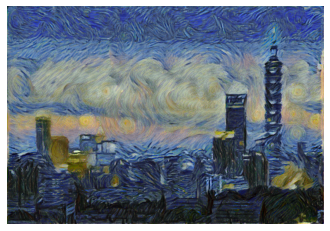

Total loss:  66105.15625
content fraction: 0.000208548135203802
style fraction: 0.9997913908906646
Iteration:  5100


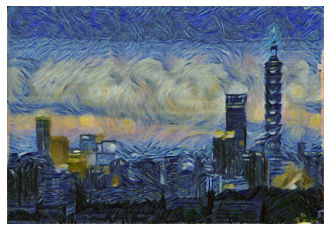

Total loss:  65007.3984375
content fraction: 0.0002120778265373145
style fraction: 0.9997879323032653
Iteration:  5400


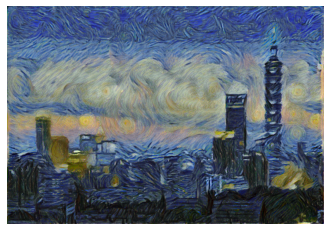

Total loss:  63462.3515625
content fraction: 0.0002173087916495936
style fraction: 0.9997827319025571
Iteration:  5700


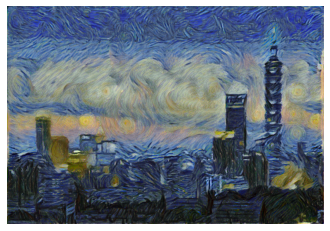

Total loss:  62258.4921875
content fraction: 0.00022175313733496855
style fraction: 0.9997782638541339
Iteration:  6000


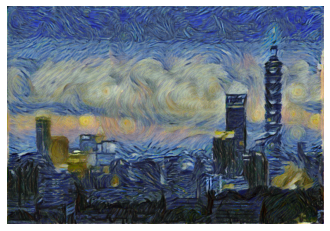

In [0]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 6000
 
height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps/300
counter = 0
for ii in range(1, steps+1):
  target_features = get_features(target, vgg)
  content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
  style_loss = 0
  
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
    _, d, h, w = target_feature.shape
    style_loss += layer_style_loss / (d * h * w)
  
  total_loss = content_weight * content_loss + style_weight * style_loss
  
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()
  
  if  ii % show_every == 0:
    print('Total loss: ', total_loss.item())
    print('content fraction:', content_weight*content_loss.item()/total_loss.item())
    print('style fraction:', style_weight*style_loss.item()/total_loss.item())
    print('Iteration: ', ii)
    plt.imshow(im_convert(target))
    plt.axis("off")
    plt.show()
    
  if ii % capture_frame == 0:
    image_array[counter] = im_convert(target)
    counter = counter + 1

The Style Transfer Loop with different range

In [0]:
for i in range(1, 1001):
  optimizer.zero_grad()
  target_features = get_features(target, vgg)
  
  content_loss = torch.mean((target_features['conv4_2'] -
                             content_features['conv4_2']) ** 2)
  
  style_loss = 0
  for layer in style_weights:
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape
    style_gram = style_grams[layer]
    layer_style_loss = style_weights[layer] * torch.mean(
      (target_gram - style_gram) ** 2)
    style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
  if i % 50 == 0:
    total_loss_rounded = round(total_loss.item(), 2)
    content_fraction = round(
      content_weight*content_loss.item()/total_loss.item(), 2)
    style_fraction = round(
      style_weight*style_loss.item()/total_loss.item(), 2)
    print('Iteration {}, Total loss: {} - (content: {}, style {})'.format(
      i,total_loss_rounded, content_fraction, style_fraction))
      
final_img = im_convert(target)

Iteration 50, Total loss: 2254429.0 - (content: 0.0, style 1.0)
Iteration 100, Total loss: 490729.22 - (content: 0.0, style 1.0)
Iteration 150, Total loss: 343156.38 - (content: 0.0, style 1.0)
Iteration 200, Total loss: 659932.44 - (content: 0.0, style 1.0)
Iteration 250, Total loss: 1024515.12 - (content: 0.0, style 1.0)
Iteration 300, Total loss: 2160894.0 - (content: 0.0, style 1.0)
Iteration 350, Total loss: 816759.19 - (content: 0.0, style 1.0)
Iteration 400, Total loss: 699948.38 - (content: 0.0, style 1.0)
Iteration 450, Total loss: 592781.44 - (content: 0.0, style 1.0)
Iteration 500, Total loss: 1207077.12 - (content: 0.0, style 1.0)
Iteration 550, Total loss: 822126.88 - (content: 0.0, style 1.0)
Iteration 600, Total loss: 1381433.5 - (content: 0.0, style 1.0)
Iteration 650, Total loss: 1665098.88 - (content: 0.0, style 1.0)
Iteration 700, Total loss: 497964.62 - (content: 0.0, style 1.0)
Iteration 750, Total loss: 869097.31 - (content: 0.0, style 1.0)
Iteration 800, Total lo

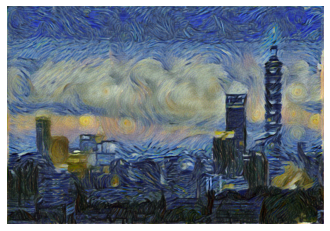

In [0]:
fig = plt.figure()
plt.imshow(final_img)
plt.axis('off')
plt.savefig('/content/results.png')

Save to the video

In [0]:
import cv2 
 
frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))
 
for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)
 
vid.release()

In [0]:
from google.colab import files
files.download('output.mp4')